# Model Evaluation

At the end of the day, we're looking for a model that will help us predict accurately in the future. So the best way to evaluate a model would be to travel forward in time from the time of model deployment until the end of time, gather up all of the model predictions, and compare them to what actually ended up happening. Obviously this isn't feasible, but we need to clearly identify what it is we're trying to optimize before we can figure out a way to get around the practical problems in estimating it.

## Evaluation Metrics

The first thing we need to do is iron out the details of what we mean by "comparing" the predictions to what actually happened. To do that, we need to come up with a rule that tells us how happy we are with a prediction $\hat y$ (in the case of regression) or $\hat p$ (in the case of probabilistic classification) if the real outcome was $y$. We'll call that rule an *evaluation metric* and denote it $M(y,\hat y)$. The absolute error $|\hat y - y|$ is one possible metric in the case of regression, as is accuracy $(\hat p > 0.5) == y$ in the case of classification. The purpose of the evaluation metric is to encode what *you* think makes a good prediction, so the sky is the limit. Maybe if you predict within 0.1 of the truth it's all the same to you, but if you're further out than that then you want to penalize quadratically. Maybe after a certain amount of error all predictions are equally bad so you don't care to penalize any more than some maximum value. It's up to you to decide.

##### EXERCISE

Write python code for an evaluation metric `def M(y, ŷ):` that returns $|\hat y - y|$ when that value is less than 10, but returns 10 otherwise. Think up a scenario where you might want to use an evaluation metric like this.

##### EXERCISE

Imagine you're using some kind of regression model to predict the roll angle (in degrees) of a drone based on video from the drone (i.e. is the drone upside down? tilting 30 degrees left?). The regression model can theoretically output any number between minus and positive infinity. One of your colleagues proposes using absolute deviation $|\hat y -y|$ as the evaluation metric, but another colleague instead proposes `def M(y, ŷ): np.abs(y-ŷ) % 360`. Which do you think is better and why?

In [1]:
# metrics to evaluate interrelated predictions?

### Metrics and Losses

The evaluation metric is a lot like a loss function in that it tells you how bad or good your prediction is relative to reality. In many cases, the evaluation metric and the loss function used to fit the model in the first place are the same (e.g. mean-squared error for both). However, there are many cases in which they are not the same. There are several reasons why you might want to use a different loss function than your evaluation metric. One common reason is that the evaluation metric you want to use is not differentiable, but the optimization algorithm you are using requires gradients. This is often the case with classification: perhaps the 1/0 classification accuracy is the metric you really care about, but, since it is not differentiable, you use the log loss (cross entropy) instead. Another possible reason is that your evaluation metric includes interactions between several model predictions and outcomes instead of just comparing them one-by-one (we won't discuss metrics like these, but know you can construct them). Or perhaps you would like to use a particular software package that has a particular loss function built into the algorithm, so you aren't free to choose it. 

All in all, you can think of the loss as a "dumbed down" version of the evaluation metric. The evaluation metric is the thing you really care about, but for the purpose of fitting a model, you're willing to use a (simpler) loss as a proxy.

## Generalization Error

Now that we have a way to quantify how good or how bad a prediction is relative to the truth, we can get back to our model evaluation problem. Let's imagine that between now and the end of time, we would gather the data $(X^{\dagger}, y^{\dagger})$, where the $\dagger$ is just there to differentiate these data from what we've observed in the past. These datasets could be either finite or infinite based on how many times we expect the model to run in the future, but either way let's call the total number of future model runs $n^\dagger$. Let's also say that the model that we've built/trained today is baked into a function $f(x)$ which in code looks something like `def f(x): model.predict(x)`, and that we've chosen an evaluation metric $M$. Then our final measure of how good our model is should be:

$$
\mathcal E(f) 
=
\frac{1}{n^\dagger} \sum^{n^\dagger}_i M(y_i^\dagger, f(x_i^\dagger))
\label{gen-error}
$$

This quantity is called the *generalization error* of the model $f$. 

The obvious problem with this is that we need to evaluate the model *now*. We don't have the data from the future at this moment, and we can't afford to wait until the end of time (also, if $n^\dagger$ is infinite, the sum might not even make sense). So because we can't calculate it directly, we have to find a way to *approximate* the generalization error.

Approximating the generalization error is *the* central problem of supervised learning. Anyone can come up with a model that produces predictions of one kind or another (using either machine learning or hand-coding), but without quantifying how good this model is likely to perform in the future, it's totally useless. 

Moreover, there is no "wrong" way to fit a model. The consequence of doing a bad job fitting a model is that your model may perform poorly. But that's ok! If you evaluate correctly, you know exactly how poor the performance is and you can try different approaches to try to improve it. On the other hand, there are many wrong ways to approximate the generalization error of a model. If you assess your model incorrectly, you will have absolutely no idea of how good your model is in reality. Furthermore, unless you think critically about the result you're seeing, you may not even have any indication that you did something wrong.

This point is so important that it bears repeating: knowing how to *evaluate* a model is more important than knowing how to *fit* a model. You should only worry about the latter once you understand the former. So keep your eye on the prize!

## Estimating Generalization Error


We want to calculate the generalization error for our model but we can't because we don't have all the future data. One approach we can use to estimate the generalization error is to calculate it using *past* data instead of *future* data. In essence, what we are assuming is that what has happened is a pretty good approximation for what will happen. The extent to which this is not true is the extent to which our approximation will be off. We'll use $\hat{\mathcal E}(f)$ to denote this approximation of the generalization error:

$$
\mathcal {\hat E}(f) 
=
\frac{1}{n} \sum^{n}_i M(y_i, f(x_i))
\label{empirical-error}
$$

Let's try this approach out with a simulation. We're going to build a little "data factory" that generates rows of data for us. We'll run it $n=1000$ times to generate our observed data $(X,y)$. Then we're going to fit a model using that data, which will give us $f$. Once we have our model, we'll estimate the generalization error $\hat{\mathcal E}(f)$ using the above formula \ref{empirical-error}. 

However, since our data is simulated, we can also simulate all of the future data $(X^\dagger,y^\dagger)$ that we will observe if we let the model run $n^\dagger=1000$ more times. Assuming we only planned on making 1000 predictions from get-go, that is all the data we need to calcualte the true generalization error $\mathcal E(f)$ using \ref{gen-error}. Then we will compare our previously estimated generalization error $\hat{\mathcal E}(f)$ to the truth $\mathcal E(f)$ to see if our approach works. We'll repeat this whole process 500 times so we can see if how good our estimates of model performance are on average.

Our data factory can be whatever we want, but for this experiment we'll set it up to generate random $x$ and $y$:

In [2]:
import numpy as np

In [23]:
def data_factory(n):
    X = np.random.random((n,5)) # 5 predictors
    y = np.random.random((n,))
    return X,y

In [24]:
X,y = data_factory(1000)

Let's look at the first 3 rows:

In [25]:
X[0:3,:],y[0:3]

(array([[0.91586927, 0.34109255, 0.18769485, 0.25513254, 0.99946363],
        [0.96560603, 0.91925419, 0.99269982, 0.36219822, 0.95019696],
        [0.7137451 , 0.79316455, 0.84880701, 0.28760566, 0.67715313]]),
 array([-0.23678489,  0.8482024 ,  0.27770748]))

Great. Now let's fit a model. I'll use a random forest model for this, but it doesn't matter if you understand how a random forest works or not- all you need to know is that it's an algorithm that takes data $(X,y)$ and produces a model $f$ that will produce new estimates of $y$ given new predictors $x$. 

In [26]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

We'll use absolute error as our evaluation metric and estimate the generalization error.

In [27]:
def metric(y,ŷ):
    return np.mean(np.abs(y-ŷ))

In [28]:
ŷ = model.predict(X)
ê = metric(y,ŷ)

Now we'll generate our "future" data and calculate the real generalization error

In [29]:
X_future, y_future = data_factory(1000)
ŷ_future = model.predict(X_future)
e = metric(y_future, ŷ_future)

Let's compare the two:

In [30]:
print(f'ê: {ê}\ne: {e}')

ê: 0.013804021647218306
e: 0.038541343476292525


This doesn't seem promising... our estimate of the generalization error is much smaller than it should be! But maybe we just got unlucky this one time. Let's repeat the simulation 500 times to make sure.

In [31]:
def simulate_model_eval():
    X,y = data_factory(1000)
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X,y)
    
    ŷ = model.predict(X)
    ê = metric(y,ŷ)
    
    X_future, y_future = data_factory(1000)
    ŷ_future = model.predict(X_future)
    e = metric(y_future, ŷ_future)
    
    return ê, e

ês, es = zip(*[simulate_model_eval() for i in range(100)])

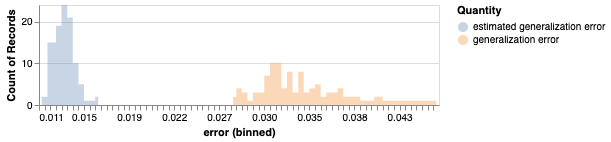

In [32]:
import pandas as pd
import altair as alt

source = pd.DataFrame({
    'estimated generalization error':ês,
    'generalization error':es
})

alt.Chart(source, height=100).transform_fold(
    ['estimated generalization error', 'generalization error'],
    as_=['Quantity', 'error']
).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('error:Q', bin=alt.Bin(maxbins=100)),
    alt.Y('count()', stack=None),
    alt.Color('Quantity:N')
)

Ouch. This shows that our estimates are of generalization error are consistently far too low. Out of curiosity, let's see if that still happens if we use a linear model instead of a random forest.

When an estimator is on average less than the quantitiy it is trying to estimate, we say that the estimator is *biased downward*. Thus $\hat{\mathcal E}$ is biased downward (for $\mathcal{E}$).

In [33]:
from sklearn.linear_model import LinearRegression

def simulate_model_eval():
    X,y = data_factory(1000)
    model = LinearRegression()
    model.fit(X,y)
    
    ŷ = model.predict(X)
    ê = metric(y,ŷ)
    
    X_future, y_future = data_factory(1000)
    ŷ_future = model.predict(X_future)
    e = metric(y_future, ŷ_future)
    
    return ê, e

ês, es = zip(*[simulate_model_eval() for i in range(500)])

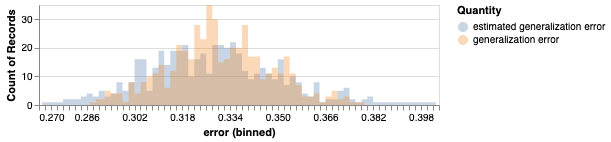

In [34]:
source = pd.DataFrame({
    'estimated generalization error':ês,
    'generalization error':es
})

alt.Chart(source, height=100).transform_fold(
    ['estimated generalization error', 'generalization error'],
    as_=['Quantity', 'error']
).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('error:Q', bin=alt.Bin(maxbins=100)),
    alt.Y('count()', stack=None),
    alt.Color('Quantity:N')
)

What the heck!? Now it looks like our estimate is pretty decent. Let's dig in a little closer and look at the distribution of exactly how far off we are in our error estimate across all simulations.

In [15]:
error_in_error_estimate = [e-ê for e,ê in zip(es, ês)]

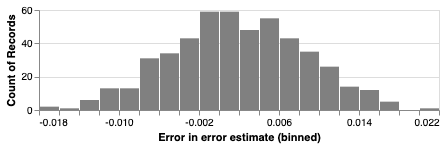

In [16]:
source = pd.DataFrame({'Error in error estimate':error_in_error_estimate})

alt.Chart(source, height=100).mark_bar(color='grey').encode(
    alt.X("Error in error estimate:Q", bin=alt.Bin(maxbins=20)),
    y='count()',
)

The plot shows that the distribution of $\mathcal E - \hat{\mathcal E}$ is slightly skewed to the right, meaning that, on average, our estimate of the generalization error is a little less than the true generalization error. So we still have the same problem as before, just to a much smaller extent.

Putting all of this together, we have to conclude that we cannot use the estimator defined in \ref{empirical-err}: we would always be underestimating the generalization error. Moreover, the reason this happens is *not* that the past data is not representative of the future data because we are using the exact same `data_factory` function to generate both datasets. Furthermore, the amount we're off by depends on what kind of model we use (and perhaps other factors we didn't investigate), so we can't even know ahead of time how much correction might be necessary. 

This is really bad news for us. If we can't estimate ahead of time how our model will perform, how can we tell which model will be better than another? How can we tell if our model is better than random guessing?

##### EXERCISE

The data factory we're using produces predictors and outcomes, but they are actually random numbers that have no relationship to each other. What if we use a data factory that uses the predictors to determine what the outcome is? Change the data factory code above to generate outcomes according to $y_i = x_1^2 + \log(x_2) - x_4x_5$ and rerun our experiments. Is the result any different?

##### EXERCISE

Repeat these experiments with a *classifier* of your choosing (e.g. `sklearn.ensemble.RandomForestClassifier`). You can use this code to generate data with binary outcomes:

```
def class_data_factory(n):
    X = np.random.random((n,5)) # 5 predictors
    y = np.random.randint(2, size=n)
    return X,y
```

Use classification accuracy as your evaluation metric. Are your estimates of generalization error still biased downward?

### Training and Test Sets

Although things look bleak at the moment, there is actually a simple solution to our problem. All we have to do is split our data up into two subsamples: one that will be used to fit the model, and one that will be used to evaluate it. The data we use to fit the model is called a *training set* and the data we use to evaluate the model is called a *test set*. 

![](https://www.dataquest.io/wp-content/uploads/kaggle_train_test_split.svg)

In other words, our new estimate of generalization error will be the *test error*:

$$
\mathcal {\hat E}_{\mathcal T}(f) 
=
\frac{1}{n^{\mathcal T}} \sum_{i \in \mathcal{T}}  M(y_i, f_{\mathcal S}(x_i))
\label{test-error}
$$

Where $\mathcal T$ (for "test") and $\mathcal S$ (for "study", since "training" also starts with a T) are a sets of indices indicating which observations are in the test and training sets, respectively. $n^{\mathcal T}$ is the number of observations in the test set. The notation $f_{\mathcal S}$ indicates that the model $f$ was fit using the training data $\mathcal S$ and not the test data. 

Compare this to the *training error*, which is basically what we were using before:

$$
\mathcal {\hat E}_{\mathcal S}(f) 
=
\frac{1}{n^{\mathcal S}} \sum_{i \in \mathcal{S}}  M(y_i, f_{\mathcal S}(x_i))
\label{training-error}
$$

We'll demonstrate the use of the test set in code first and then explain why it works.

In [17]:
def simulate_model_eval():
    X,y = data_factory(1000)
    
    S = range(500) # training set
    T = range(500,1000) # test set index
    
    X_train, y_train = X[S,:], y[S] # take the first 500 rows as training data
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    
    X_test, y_test = X[T,:], y[T] # take the last 500 rows as test data
    ŷ_test = model.predict(X_test)
    ê = metric(y_test, ŷ_test)
    
    X_future, y_future = data_factory(1000)
    ŷ_future = model.predict(X_future)
    e = metric(y_future, ŷ_future)
    
    return ê, e

ês, es = zip(*[simulate_model_eval() for i in range(500)])

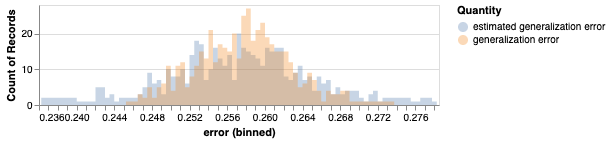

In [18]:
import pandas as pd
import altair as alt

source = pd.DataFrame({
    'estimated generalization error':ês,
    'generalization error':es
})

alt.Chart(source, height=100).transform_fold(
    ['estimated generalization error', 'generalization error'],
    as_=['Quantity', 'error']
).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('error:Q', bin=alt.Bin(maxbins=100)),
    alt.Y('count()', stack=None),
    alt.Color('Quantity:N')
)

This looks much, much better than it did when we were using random forests before. Now our estimates of generalization error are quite good on average. 

To figure out why this works we have to think about what the difference is between the test set $(X^{\mathcal T}, y^{\mathcal T})$ and the full observed data $(X, y)$ in terms of how well each of those sets approximate the future data $(X^\dagger, y^\dagger)$. In terms of what the data themselves are, there is clearly no substantive difference between the test set and the full observed data except that the test set is a subset of the observed data. But using a smaller random sample to estimate the generalization error isn't what's fixing the problem, which we can substantiate with an experiment:

In [21]:
def simulate_model_eval():
    X,y = data_factory(1000)
    
    T = range(500,1000) # subset index
    
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X, y) # fit on the full dataset
    
    X_test, y_test = X[T,:], y[T] # take the last 500 rows to estimate the generalization error
    ŷ_test = model.predict(X_test)
    ê = metric(y_test, ŷ_test)
    
    X_future, y_future = data_factory(1000)
    ŷ_future = model.predict(X_future)
    e = metric(y_future, ŷ_future)
    
    return ê, e

ês, es = zip(*[simulate_model_eval() for i in range(100)])

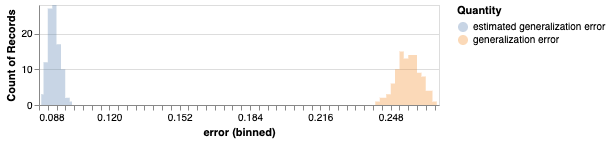

In [22]:
source = pd.DataFrame({
    'estimated generalization error':ês,
    'generalization error':es
})

alt.Chart(source, height=100).transform_fold(
    ['estimated generalization error', 'generalization error'],
    as_=['Quantity', 'error']
).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('error:Q', bin=alt.Bin(maxbins=100)),
    alt.Y('count()', stack=None),
    alt.Color('Quantity:N')
)

##### EXERCISE

The code above corresponds to the estimator 

$$
\mathcal {\hat E}(f) 
=
\frac{1}{n^{\mathcal T}} \sum_{i \in \mathcal{T}}  M(y_i, f_{\mathcal S \cup \mathcal T}(x_i))
\notag
$$

Use the code and the expression above to explain in your own words what this estimator is doing.

The real difference is not what's in the data or how much of it there is, but *how it is used*. The test set is not used to fit the model $f_{\mathcal S}$, whereas the training set is. This matters because *future* data also cannot ever be used to fit the model since it's data we don't even have at the time the model is fit. In that sense, the test set is a much better approximation of future data than the training data are because, like the future data, the test data are not used to fit the model. The very fact that we have observed the training data and used it to fit the model makes it unsuitable as an approximation to future data, even though we have done nothing to change the data itself!

We're going to dig into this further, but for now it might be useful to think of an analogy. Imagine that a student is taking a course whose ultimate goal is to prepare the student to do well in their future career. The course includes both practice problems (with solutions) and a final exam. How can the student make sure she is prepared to succeed in the future? If the student studies using the practice problems, but then evaluates her performance using those same practice problems, she will always be optimistic about what she has actually learned. She may have simply memorized the answers to those problems or learned certain tricks that only work for those problems. However, her performance on the final exam, which has problems she has never seen before, is more likely to indicate how successful she will be in the future, since she will encounter new problems in her career, not textbook problems.

### Generalization Error Revisited

We originally presented the generalization error as an average over all future data. That's probably the easiest way to think of it, but it isn't actually the way that we most often work with it mathematically. Mathematically, the generalization error is actually

$$
\mathcal {E}(f) 
=
E_{X, Y}[ M(Y, f(X)) ]
\label{real-gen-error}
$$

where the expectation is taken over the joint distribution of the random variables $X$ and $Y$. Notice that our fit model $f$ is a fixed function, although $X$ and $Y$ are random. 

Now we can see a little more clearly why our training set estimator (equation \ref{training-error}) doesn't work: it's approximating something like $\mathcal {E}_{\mathcal S}(f) = E_{X, Y}[ M(Y, f_{X,Y}(X)) ]
$. We're trying to average over the variation in model performance on the "future" data $X$ and $Y$, but we're using that "future" data to fit the model $f_{X,Y}$ at the same time. In fact, the notation $\mathcal {E}_{\mathcal S}(f)$ doesn't even make sense because $f$ isn't even a fixed function that we're evaluating inside the estimator - it changes along with the data. So what we're evaluating with the theoretical quantity $\mathcal {E}_{\mathcal S}$ isn't even clear.

On the other hand, the test set estimator (equation \ref{test-error}) just replaces the expectation in \ref{real-gen-error} with a finite average, but keeps $f$ fixed when computing that average. Thus, if you take the expected value of the test-set estimator, you get back the generalization error:
$$
\begin{array}{rcl}
E[\hat{\mathcal E}_{\mathcal T}(f)] &=& E\left[ \frac{1}{n^{\mathcal T}} \sum_{i \in \mathcal{T}} M(Y, f_{\mathcal S}(X)) \right] \\
&=&  \frac{1}{n^{\mathcal T}} \sum_{i \in \mathcal{T}} E\left[ M(Y, f_{\mathcal S}(X)) \right] \\
&=& \frac{n^{\mathcal T}}{n^{\mathcal T}} \mathcal E(f)
\end{array}
$$

The math is easy here because the expectation passes through the sum, after which the quantity on the inside of the sum is recognizable as the generalization error. If you try and do the same for the training error, you will end up with a quantity inside the sum that looks like the aforementioned $E_{X, Y}[ M(Y, f_{X,Y}(X))]$. That's usually impossible to work with analytically because you have to factor in how the model gets fit from the data. Point being: the test error is (on average) the generalization error, but it's very hard in general to know how the training error will relate to the generalization error.

To demonstrate the difference, we can simulate both training and test errors. Each simulation is like a single draw from the joint distribution of $X$ and $Y$. First we set up the functions that we will call to compute a singe training error and a single test error:

In [55]:
def training_error():
    X_train, y_train = data_factory(500)           # randomness across different simulation runs comes from here
    model = RandomForestRegressor(n_estimators=50)
    model.fit(X_train, y_train)                    # model depends on the random data
    ŷ_train = model.predict(X_train)
    return metric(y_train, ŷ_train)                # evaluating a moving (random) target against random data

In [54]:
X_train, y_train = data_factory(500)    
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train, y_train)                     # model fixed in advance

def test_error():
    X_test, y_test = data_factory(500)          # randomness across different simulation runs comes from here
    ŷ_test = model.predict(X_test)
    return metric(y_test, ŷ_test)               # evaluating a fixed target against random data

And now we repeat over 500 simulations:

In [46]:
ê_S, ê_T = zip(*[(training_error(), test_error()) for i in range(500)])

Notice that the code to fit the model is inside of the `training_error` function, but outside of the `test_error` function. Thus the model $f$ will be *refit* each time we compute a training error, but is treated as *fixed* when computing each test error. This difference only becomes clear when you do a simulation you can repeat many times, since using a single dataset the model only gets fit once and you don't get to see where the "randomness" enters. When doing simulations, you can see that the randomness enters before the model is even fit when using the training error estimate of generalization error. The randomness only enters after the model has been fit when using the test error estimate of generalization error.

When we plot the training and test errors, we can see that the training error (which is not an accurate estimate of generalization error) is usually smaller than the test error (which is). In other words, if we use the training error, we will usually overestimate the performance of our model. 

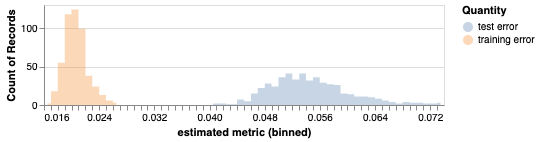

In [50]:
source = pd.DataFrame({
    'training error':ê_S,
    'test error':ê_T
})

alt.Chart(source, height=100).transform_fold(
    ['training error', 'test error'],
    as_=['Quantity', 'estimated metric']
).mark_area(
    opacity=0.3,
    interpolate='step'
).encode(
    alt.X('estimated metric:Q', bin=alt.Bin(maxbins=100)),
    alt.Y('count()', stack=None),
    alt.Color('Quantity:N')
)

## The Geometry of Generalization, Training, and Test Errors

We've demonstrated that training error is a poor estimate of generalization error and specifically that it tends to underestimate the generalization error. But why should training error tend to underestimate instead of overestimate? And why is it that the effect is more pronounced when we use a random forest, but much less pronounced when we use linear regression?

We're going to draw a picture that will help answer these questions and many more. To start, we'll imagine the space of *all possible functions* of the predictors and we'll call that $\mathbb F$. So, for example, if there is a single predictor $x$, then you can imagine that space is something like $\mathbb F = \{10.2 \dots, x^2, \dots \log(x) + \frac{1}{x}, \dots\}$ so that each element of $\mathbb F$ is some function of $x$ and every possible function of $x$ (of which there are infinite) is contained in $\mathbb F$. 

The the absolute best possible model we could ever have would be 

$$
f^\dagger = \underset{f \in \mathbb F}{\text{argmin}} \ \  \mathcal E (f)
$$

In other words, we'll find the function out of all the possible functions in $\mathbb F$ that minimizes the generalization error and call that function $f^\dagger$. By definition, it's not possible to find a better model than that.

In general, there could be multiple functions that simultaneously minimize the generalization error, so $f^\dagger$ might be a set instead of a single point. We'll illustrate it as a point in these figures because it's easier to understand, but the arguments work the same if you draw it as a space instead. In this case, the "distances" are the distance from each point to a boundary of the space.

In general, $\mathcal E(f^\dagger) \ne 0$ but there's no point in carrying around the extra $\mathcal E(f^\dagger)$ everywhere because when we compare distances (say $f_a \leftrightarrow f^\dagger = \mathcal E(f_a) - \mathcal E(f^\dagger)$ vs $f_b \leftrightarrow f^\dagger =  \mathcal E(f_b) - \mathcal E(f^\dagger)$), the $\mathcal E(f^\dagger)$ term drops out (i.e. we get $\mathcal E(f_a) - \mathcal E(f_b))$.

Now we can define the "distance" between $f^\dagger$ and any point $f$ as $\mathcal E(f) - \mathcal E(f^\dagger)$. To simplify things, let's assume that $\mathcal E(f^\dagger)$ is 0 so that the generalization error $\mathcal E(f)$ represents the distance between our estimated model $f$ and the best possible model we could have estimated $f^\dagger$.

Now let's consider fitting a model. We don't know what the best possible model $f^\dagger$ is - for multiple reasons: 1) We can't calculate the expectation over the data-generating distribution because we don't know what that distribution is, and, 2) even if we did, there would be no way to optimize the generalization error over the space of all possible functions. 

What we do get to observe are the data $X,y$ in the training set $\mathcal S$. That "solves" the problem of not knowing the data-generating distribution in the sense that we can approximate the expectation over the distribution with an average over the observed data points. That's $\hat {\mathcal E}_{\mathcal S}(f)$. Now imagine we could find the function in $\mathbb F$ that would optimize this training error:  

$$
f_{\mathcal S} = \underset{f \in \mathbb F}{\text{argmin}} \ \  \hat{\mathcal E}_{\mathcal S} (f)
$$

Unfortunately, we also can't find $f_{\mathcal S}$ because it's not possible (for reasons discussed in previous chapters) to search over the entire space $\mathbb F$. Thus we restrict our search for a model to some smaller space. We call this the model space $\mathcal F$, which is the space of all functions that we are willing to consider for our model $f$. For instance, if we are fitting a cubic model $\hat y_i = a x_i^3 + b x_i^2 + c x_i + d$, we are only considering elements of $\mathbb F$ that have that particular form. So a function like $\log(x) + \frac{1}{x}$ would be in $\mathbb F$, but not in $\mathcal F$. Using a smaller model space is a workaround for the second problem because we are substituting $\mathcal F$ for $\mathbb F$:

$$
f = \underset{f \in \mathcal F}{\text{argmin}} \ \  \hat{\mathcal E}_{\mathcal S} (f)
$$

And this expression neatly represents the three components of the supervised learning problem: 1) the model space $\mathcal F$, 2) the loss function $\hat{\mathcal E}_{\mathcal S}(f)$, and the optimization algorithm that ends up implementing the $\text{argmin}$ operation. The result is the fit model $f$.

We're used to seeing the loss expressed as $L(y, \hat y)$, so how is the training error $\hat{\mathcal E}_{\mathcal S}(f)$ the same as that? Well, if the loss function and the evaluation metric are the same, you'll be able to see how $L(y, \hat y)$ is the same as $\hat{\mathcal E}_{\mathcal S}(f)$ once you write them both out. If the loss and the evaluation metric are *not* the same, then you can think of the loss as an approximation to the evaluation metric. By finding the model that minimizes the loss, we're hoping to find one that does well in terms of the evaluation metric too. 

$\hat{\mathcal E}_{\mathcal S} (f_\mathcal S)$ will actually always be 0 assuming $x_i \ne x_j$ since there is always a function that can perfectly interpolate any finite set of points. Furthermore, there are always an infinite number of interpolating functions, so $f_\mathcal S$ will actually be a set in its own right. As before, we'll draw it as a point to simplify the presentation.

Now we can also define a distance between $f_\mathcal{S}$, the model that theoretically optimizes the training error, and any model $f$ as $\hat{\mathcal E}_{\mathcal S} (f) - \hat{\mathcal E}_{\mathcal S} (f_\mathcal S)$, similar to what we did before with the true generalization error and $f^\dagger$. And, as before, we can drop the $\hat{\mathcal E}_{\mathcal S} (f_\mathcal S)$ so that the training error $\hat{\mathcal E}_{\mathcal S} (f)$ represents the distance between the estimated model $f$ and the model with the best possible training error $f_\mathcal{S}$.

When we solve our optimization problem to find $f$, we're looking for the model $\mathcal F$ that minimizes the training error. Another way of looking at that is that we're finding the point in $\mathcal F$ that is closest to $f_{\mathcal S}$ (in the hopes that $f_{\mathcal S}$ is close to $f^\dagger$).